In [102]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [103]:

bag = rosbag.Bag('/home/uware/rosbags/21h7_slz_2-4-6-8-10_360_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4]

In [104]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [105]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,0.229646
1,3.023775,2.483468
2,3.225893,2.632362
3,3.328386,2.646282
4,3.432558,2.659897
...,...,...
1170,69.441232,2.274457
1171,74.009911,3.391549
1172,100.176655,2.019595
1173,100.215865,2.019595


<AxesSubplot:xlabel='relative_time'>

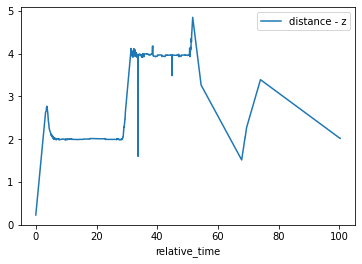

In [106]:
# initial graph
df.plot(x='relative_time', y=target)

In [107]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .01)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [108]:
# the amount of data points we are left with
len(x[peaks])

184

In [109]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

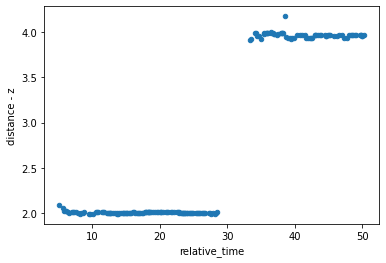

In [110]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [111]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
27,5.173159,2.091735,2
40,5.679015,2.054430,2
43,5.795512,2.025413,2
50,6.073917,2.020829,2
52,6.153369,2.024884,2
...,...,...,...
1124,49.739366,3.966780,4
1126,49.811083,3.965856,4
1128,49.884381,3.959385,4
1131,49.992043,3.959082,4


In [112]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [113]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [114]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
27,5.173159,2.091735,2,-0.091735
40,5.679015,2.054430,2,-0.054430
697,33.357289,3.919515,4,0.080485
701,33.508986,3.930642,4,0.069358


In [115]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,114.0,-0.004949,0.012794,-0.091735,-0.012791,-0.003119,0.003364,0.011118
4,70.0,0.032239,0.031888,-0.176130,0.018659,0.033031,0.041518,0.080485


In [116]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

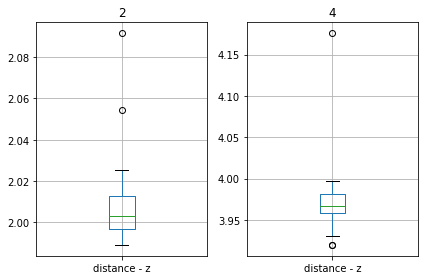

In [117]:
box_plotter(target)

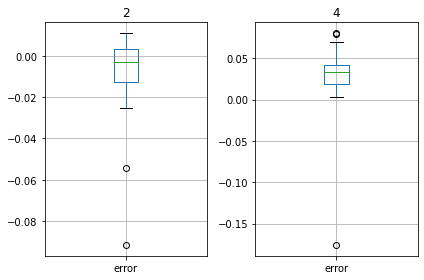

In [118]:
box_plotter('error')